In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

Step 0: load our data

In [3]:
# Load data
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/MSc thesis/processed_data/metadata/fully_concatenated_data.csv", lineterminator='\n')

In [4]:
# List of image and text feature columns to keep
image_columns = [f'image_{i}' for i in range(0, 2049)]
text_columns = [f'text_{i}' for i in range(0, 768)]

# Additional columns you want to keep
additional_columns_to_keep = ['like_count', 'comment_count', 'post_id', 'Followers', 'Username', 'Followees', 'Posts',
                              'Month', 'Day of Week (String)', 'Hour', 'Language', 'Is_English', 'Image_Count', 'Sponsorship label', 'is_video']

# Combine both lists of columns to keep
columns_to_keep = additional_columns_to_keep + text_columns + image_columns

# Drop all columns except those specified in columns_to_keep
columns_to_drop = [col for col in data.columns if col not in columns_to_keep]

# Drop the unwanted columns from the dataframe
data_2 = data.drop(columns=columns_to_drop)


# Maybe don't delete category and detected languages
# Same with comments disabled and video
# potential columns to add or not:
#'comments_disabled',
#'is_video'
# Category
data_2.head(10)

,Username,post_id,like_count,comment_count,is_video,Sponsorship label,Followers,Followees,Posts,Month,...,text_758,text_759,text_760,text_761,text_762,text_763,text_764,text_765,text_766,text_767
0,00_rocketgirl,1354915397698488656,293,6,False,0,6453,710,1059,10,...,-0.155746,-0.017703,-0.091135,0.058261,0.159358,0.032952,-0.012526,-0.204870,0.062999,0.075272
1,00_rocketgirl,1666974101448132749,73,2,False,0,6453,710,1059,12,...,-0.247792,0.015757,-0.037442,-0.018389,0.203054,0.074983,0.049237,-0.213263,-0.012400,0.147600
2,00_rocketgirl,1768273356099895999,164,4,False,0,6453,710,1059,4,...,-0.089539,-0.097885,-0.226008,0.053440,0.047846,0.004013,-0.182280,-0.174142,0.094179,0.080168
3,00_rocketgirl,1770557472379860655,474,18,False,0,6453,710,1059,5,...,-0.215643,-0.101936,-0.123704,0.029802,0.113963,0.098773,-0.108283,-0.082098,0.045219,0.057346
4,00_rocketgirl,1899586748141399903,116,2,False,0,6453,710,1059,10,...,-0.112963,-0.036261,-0.078814,0.114615,0.149342,0.011751,-0.150317,-0.156846,0.141513,0.093924
5,0720_b,1828882589862019412,1835,13,False,0,31521,2202,601,7,...,0.013015,-0.100801,-0.067726,0.076079,0.248161,0.093687,-0.052417,-0.504811,0.080545,-0.086281
6,0720_b,1996580229074923796,1170,2,False,0,31521,2202,601,3,...,0.027090,-0.154764,-0.085396,0.070190,0.285331,0.098012,-0.022090,-0.441710,0.055267,-0.116288
7,0720_b,2021587997624266181,820,2,False,0,31521,2202,601,4,...,0.043861,-0.152151,-0.037170,0.045965,0.204610,0.092008,-0.048374,-0.509754,0.074065,-0.092127
8,0720_b,2021587997624266181,820,2,False,0,31521,2202,601,4,...,0.043861,-0.152151,-0.037170,0.045965,0.204610,0.092008,-0.048374,-0.509754,0.074065,-0.092127
9,0hkris,1514786978688118458,269,0,False,0,12630,7069,261,5,...,-0.147682,-0.036988,-0.208915,0.104713,0.120187,0.093342,0.097392,-0.009471,0.012900,0.064740


In [5]:
# Filter image count to 10 or less, which is what is realistic in the industry
data_2 = data_2[data_2['Image_Count'] <= 1]

# Columns to one-hot encode
columns_to_encode = ['Month', 'Hour', 'Day of Week (String)']

# Apply one-hot encoding
data_2 = pd.get_dummies(data_2, columns=columns_to_encode)

# Find the new one-hot encoded columns
encoded_columns = data_2.columns[data_2.columns.str.startswith(tuple(columns_to_encode))]

# Convert only the new one-hot encoded columns and boolean columns to int
data_2[encoded_columns] = data_2[encoded_columns].astype(int)

# Convert English column to integer
data_2['Is_English'] = data_2['Is_English'].astype(int)
data_2['is_video'] = data_2['is_video'].astype(int)
data_2['Sponsorship label'] = data_2['Sponsorship label'].astype(int)

Step 1: group and split the data by post_id

Define a popularity variable

In [6]:
# Set the engagement rate variable
data_2['popularity'] = (((data_2['like_count'] + data_2['comment_count'])/data_2['Followers']))

Let's split the data!

In [7]:
# Define the number of iterations and an array to store accuracies
n_iterations = 3
accuracies = []

for seed in range(n_iterations):
    print(f"Iteration {seed+1}")

    # Split users into training and temporary sets with a new seed each time
    train_users, temp_users = train_test_split(data_2['Username'].unique(), test_size=0.2, random_state=seed)
    val_users, test_users = train_test_split(temp_users, test_size=0.5, random_state=seed)

    # Assign posts to training, validation, and test sets
    train_data = data_2[data_2['Username'].isin(train_users)]
    val_data = data_2[data_2['Username'].isin(val_users)]
    test_data = data_2[data_2['Username'].isin(test_users)]

    # Normalize the selected features
    columns_to_normalize = ['Followers', 'Followees', 'Posts']
    scaler = StandardScaler().fit(train_data[columns_to_normalize])
    train_data.loc[:, columns_to_normalize] = scaler.transform(train_data[columns_to_normalize])
    val_data.loc[:, columns_to_normalize] = scaler.transform(val_data[columns_to_normalize])
    test_data.loc[:, columns_to_normalize] = scaler.transform(test_data[columns_to_normalize])

    # Calculate the median popularity rate for each dataset
    median_popularity_rate_train = train_data['popularity'].quantile(0.5)
    train_data.loc[:, 'popularity'] = (train_data['popularity'] > median_popularity_rate_train).astype(int)
    median_popularity_rate_val = val_data['popularity'].quantile(0.5)
    val_data.loc[:, 'popularity'] = (val_data['popularity'] > median_popularity_rate_val).astype(int)
    median_popularity_rate_test = test_data['popularity'].quantile(0.5)
    test_data.loc[:, 'popularity'] = (test_data['popularity'] > median_popularity_rate_test).astype(int)

    # Prepare data for XGBoost
    X_train = train_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers'], axis=1)
    y_train = train_data['popularity']
    X_val = val_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers'], axis=1)
    y_val = val_data['popularity']
    X_test = test_data.drop(['popularity', 'post_id', 'like_count', 'comment_count', 'Username', 'Image_Count', 'Followers'], axis=1)
    y_test = test_data['popularity']

    # Create the model
    model_b = Sequential()

    # Assume X_train is your training data loaded previously with correct dimensions
    # Add new layers
    model_b.add(Dense(64, input_shape=(X_train.shape[1],), activation='relu'))
    model_b.add(Dropout(0.5))
    model_b.add(Dense(32, activation='relu'))
    model_b.add(Dense(1, activation='sigmoid'))

    # Initialize the Adam optimizer with a specific learning rate
    optimizer = Adam(learning_rate=0.001)

    #Compiling the model
    model_b.compile(optimizer= optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

    # Set up early stopping
    early_stopping = EarlyStopping(monitor = 'val_accuracy',
                               patience = 20,
                               restore_best_weights = True)
    # Fit the model
    history = model_b.fit(X_train,
                      y_train,
                      epochs=500,
                      batch_size=128,
                      validation_data = (X_val, y_val),
                      callbacks=[early_stopping])

    test_loss, test_acc = model_b.evaluate(X_test, y_test)

    # Evaluate the model on the test set
    y_pred_prob = model_b.predict(X_test)
    y_pred_binary = (y_pred_prob > 0.5).astype(int)
    accuracy = accuracy_score(y_test, y_pred_binary)
    accuracies.append(accuracy)

    print(f"Accuracy for iteration {seed+1}: {accuracy:.2f}")

# Calculate the average accuracy across all iterations
average_accuracy = np.mean(accuracies)
print(f"Average Accuracy across {n_iterations} iterations: {average_accuracy:.2f}")

Iteration 1
Epoch 1/500
836/836 [==============================] - 8s 5ms/step - loss: 0.6829 - accuracy: 0.5521 - val_loss: 0.6647 - val_accuracy: 0.5999
Epoch 2/500
836/836 [==============================] - 3s 4ms/step - loss: 0.6664 - accuracy: 0.5808 - val_loss: 0.6565 - val_accuracy: 0.6226
Epoch 3/500
836/836 [==============================] - 3s 4ms/step - loss: 0.6548 - accuracy: 0.5994 - val_loss: 0.6440 - val_accuracy: 0.6364
Epoch 4/500
836/836 [==============================] - 3s 4ms/step - loss: 0.6484 - accuracy: 0.6085 - val_loss: 0.6422 - val_accuracy: 0.6360
Epoch 5/500
836/836 [==============================] - 3s 4ms/step - loss: 0.6429 - accuracy: 0.6148 - val_loss: 0.6376 - val_accuracy: 0.6431
Epoch 6/500
836/836 [==============================] - 3s 4ms/step - loss: 0.6381 - accuracy: 0.6221 - val_loss: 0.6417 - val_accuracy: 0.6416
Epoch 7/500
836/836 [==============================] - 3s 4ms/step - loss: 0.6340 - accuracy: 0.6268 - val_loss: 0.6387 - val_accu

In [8]:
# Alternatively, using numpy to generate bootstrap samples and calculate the percentiles
# Determine the size of the accuracies array
n = len(accuracies)
bootstrap_samples = np.random.choice(accuracies, (10000, n), replace=True)
ci_lower = np.percentile(bootstrap_samples, 2.5)
ci_upper = np.percentile(bootstrap_samples, 97.5)

print(f"Bootstrap 95% Confidence Interval: {ci_lower:.5f} - {ci_upper:.5f}")

Bootstrap 95% Confidence Interval: 0.63991 - 0.66126


415/415 [==============================] - 1s 2ms/step
[[0.33049694]
 [0.2828884 ]
 [0.20246536]
 ...
 [0.5643172 ]
 [0.47557542]
 [0.5500269 ]]


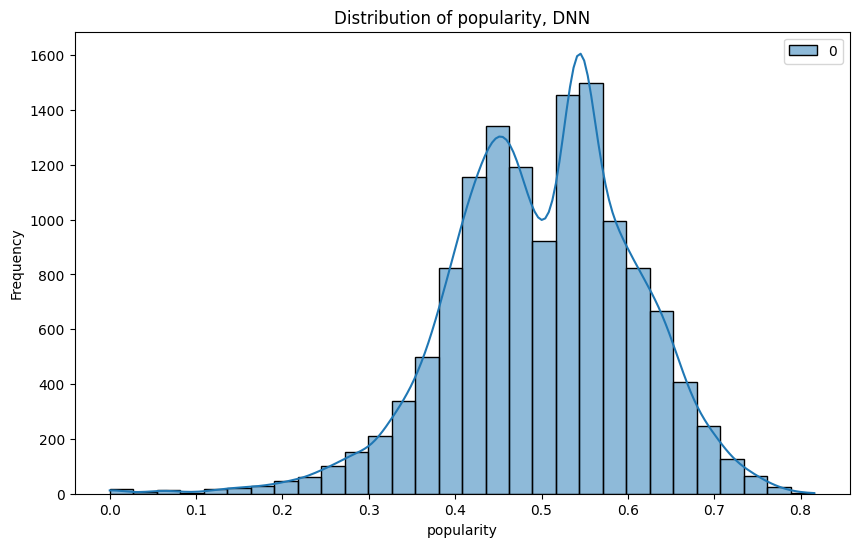

In [9]:
y_pred = model_b.predict(X_test)
print(y_pred)

plt.figure(figsize=(10, 6))
sns.histplot(y_pred, bins=30, kde=True)
plt.title('Distribution of popularity, DNN')
plt.xlabel('popularity')
plt.ylabel('Frequency')
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/DNN_predicted_popularity_value.png')  # Saving the plot
plt.show()

425/425 [==============================] - 1s 2ms/step


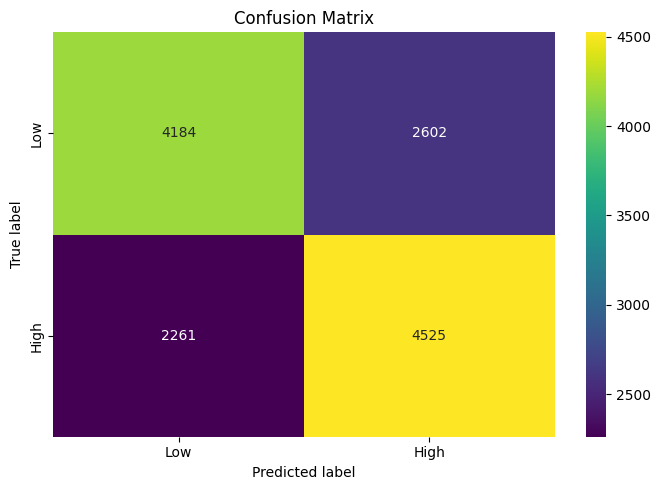

              precision    recall  f1-score   support

         Low       0.65      0.62      0.63      6786
        High       0.63      0.67      0.65      6786

    accuracy                           0.64     13572
   macro avg       0.64      0.64      0.64     13572
weighted avg       0.64      0.64      0.64     13572



In [10]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test, type_of_model):
    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(X_test)
    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

    # Show plot
    plt.show()

    # Print the classification report
    print(clr)

# Example usage
evaluate_model(model_b, X_val, val_data['popularity'], 'LightGBM')


414/414 [==============================] - 1s 2ms/step


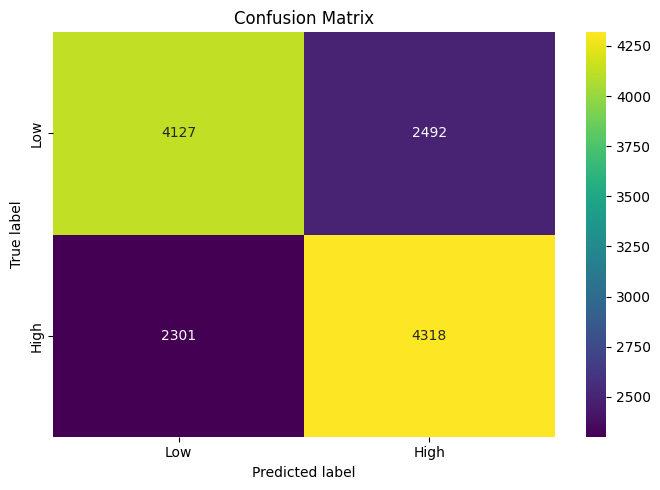

              precision    recall  f1-score   support

         Low       0.64      0.62      0.63      6619
        High       0.63      0.65      0.64      6619

    accuracy                           0.64     13238
   macro avg       0.64      0.64      0.64     13238
weighted avg       0.64      0.64      0.64     13238



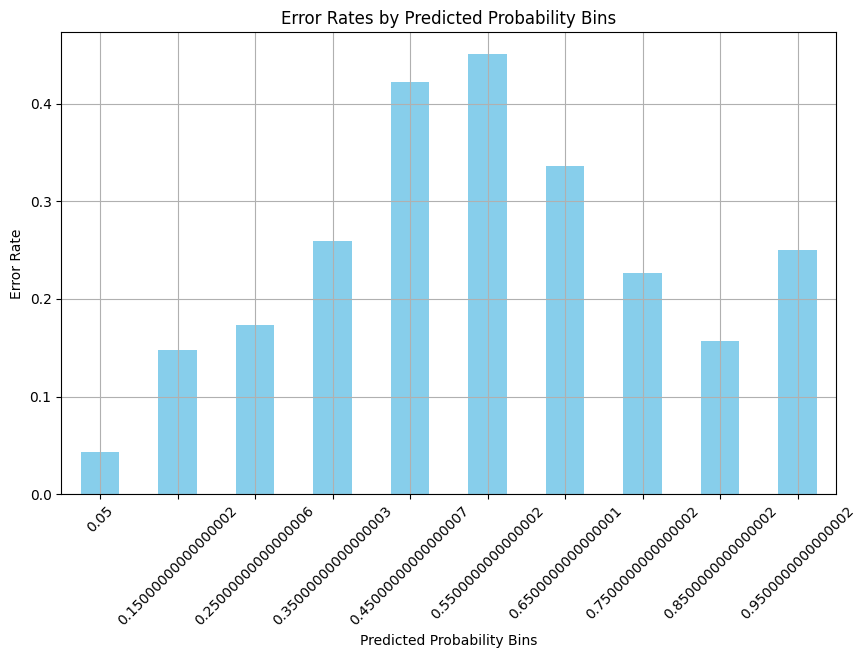

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def evaluate_model_and_error_rates(model, X_test, y_test):
    # Predicting the probabilities for the test set
    y_pred_prob = model.predict(X_test).flatten()

    # Convert probabilities to binary labels
    y_pred = (y_pred_prob > 0.5).astype(int)

    # y_test should already be binary labels
    y_true = y_test.astype(int)

    # Generating the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Generating the classification report
    clr = classification_report(y_true, y_pred, target_names=['Low', 'High'])

    # Plotting the confusion matrix
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='viridis', xticklabels=['Low', 'High'], yticklabels=['Low', 'High'])
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/DNN_confusion_matrix.png')  # Saving the plot
    plt.show()

    # Print the classification report
    print(clr)

    # Calculate error rates by probability bins
    results = pd.DataFrame({
        'y_true': y_true,
        'y_pred_prob': y_pred_prob
    })

    results['prob_bin'] = pd.cut(results['y_pred_prob'], bins=np.arange(0, 1.1, 0.1), labels=np.arange(0.05, 1.05, 0.1))

    # Calculate error rates
    error_rates = results.groupby('prob_bin').apply(
        lambda x: np.mean(x['y_true'] != (x['y_pred_prob'] > 0.5))
    )

    # Plotting error rates by predicted probability bins
    plt.figure(figsize=(10, 6))
    error_rates.plot(kind='bar', color='skyblue')
    plt.title('Error Rates by Predicted Probability Bins')
    plt.xlabel('Predicted Probability Bins')
    plt.ylabel('Error Rate')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/DNN_error_rates_by_prob_bins.png')  # Saving the plot
    plt.show()

# Example usage
evaluate_model_and_error_rates(model_b, X_test, test_data['popularity'])

Let's add some SHAP values!

In [12]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 11.8 MB/s eta 0:00:00


In [15]:
import shap
import matplotlib.pyplot as plt
import numpy as np

# Assuming the model is trained and X_test, X_train are defined
background = X_train.iloc[:100].values  # using 100 sample data points as background

# Initialize the SHAP DeepExplainer
explainer = shap.DeepExplainer(model_b, background)

In [16]:
# Calculate SHAP values
shap_values = explainer.shap_values(X_test)

# SHAP Force Plot for the first prediction
shap.initjs()
fig, ax = plt.subplots()
shap.force_plot(explainer.expected_value[0], shap_values[0][0], X_test.iloc[0], matplotlib=True, show=False)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/DNN_force_plot.png')
plt.close(fig)

# SHAP Summary Plot (Bar)
shap.summary_plot(shap_values[0], X_test, plot_type="bar", show=False)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/DNN_summary_bar_plot.png')
plt.close()

# SHAP Summary Plot (Dot)
shap.summary_plot(shap_values[0], X_test, show=False)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/DNN_summary_dot_plot.png')
plt.close()

# SHAP Decision Plot for a subset of data points
shap.decision_plot(explainer.expected_value[0], shap_values[0][:100], X_test.iloc[:100], show=False)
plt.savefig('/content/drive/MyDrive/Colab Notebooks/MSc thesis/Modeling/Out/DNN_decision_plot.png')
plt.close()

KeyError: 0